In [2]:
import os

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

from src import ppi


In [3]:
def get_project_rootpath():
    path = os.path.realpath(os.curdir)
    while True:
        for subpath in os.listdir(path):
            # PyCharm项目中，'.idea'是必然存在的，且名称唯一
            if '.idea' in subpath:
                return path
        path = os.path.dirname(path)


os.chdir(get_project_rootpath())
# 文件路径

PPI_PATH = 'data/network/PPI-Network.txt'
CANDIDATE_NAME_PATH = 'data/candidate_genes.txt'
CANDIDATE_ID_PATH = 'data/candidate_id.txt'
GENECOUNT_PATH = 'data/genecount.xls'
EMB_ROOT_PATH = 'data/emb/'
LINE_EMB_ROOT_PATH = os.path.join(EMB_ROOT_PATH, 'line')

In [4]:
nx_ppi_network, ppi_id_list = ppi.get_ppi_network(PPI_PATH)

In [5]:
def parse_line_emb(file_name, positive_gene_id_set, risklevel):
    data = file_name.strip().split('_')
    # 计算维度
    dim = int(data[1].rstrip('.emb')[1:])

    # 训练特征和label
    file_path = os.path.join(LINE_EMB_ROOT_PATH, file_name)
    with open(file_path, 'r') as f:
        data = [line.strip().split() for line in f.readlines()[1:]]
    X = [line[1:] for line in data]
    target = [1 if int(line[0]) in positive_gene_id_set else 0 for line in data]
    X = np.asarray(X, dtype=float)
    target = np.asarray(target, dtype=int)

    # 权重
    class_weight = compute_class_weight(class_weight='balanced', classes=[0, 1], y=target)
    keys = risklevel.keys()
    sample_weights = [risklevel[int(line[0])] * class_weight[1]
                      if int(line[0]) in keys else class_weight[0] for line in data]
    return dim, X, target, sample_weights


In [6]:
from sklearn.model_selection import train_test_split
from sklearn import metrics


class Cmodel():
    def __init__(self, features, labels, sample_weights):
        self.y_score = None
        self.y_pred = None
        self.features = features
        self.labels = labels
        self.model = None
        self.features_train, self.features_test, self.labels_train, self.labels_test, self.weights_train, self.weights_test = train_test_split(
            features, labels, sample_weights, test_size=0.3)

    def set_model(self, model):
        self.model = model

    def training(self):
        self.model.fit(self.features_train, self.labels_train, sample_weight=self.weights_train)
        self.y_pred = self.model.predict(self.features_test)
        # svm没有score
        # self.y_score = self.model.predict_proba(self.features_test)[:, 1]
        return

    def evaluation(self):
        # 计算准确率
        acc = metrics.accuracy_score(y_pred=self.y_pred, y_true=self.labels_test)
        # 计算精确率和召回率
        precision = metrics.precision_score(y_true=self.labels_test, y_pred=self.y_pred)
        recall = metrics.recall_score(y_true=self.labels_test, y_pred=self.y_pred)
        # 计算F1分数和AUC
        f1 = metrics.f1_score(y_true=self.labels_test, y_pred=self.y_pred)
        # auc = metrics.roc_auc_score(y_true=self.labels_test, y_score=self.y_score)
        # 混淆矩阵
        confusion_matrix = metrics.confusion_matrix(y_true=self.labels_test, y_pred=self.y_pred)
        # 结果报告
        return acc, precision, recall, f1, confusion_matrix

    def classify_report(self):
        report = metrics.classification_report(y_true=self.labels_test, y_pred=self.y_pred, digits=4)
        return report


In [7]:
positive_gene_id_set, risk_level = ppi.set_candidate_gene(GENECOUNT_PATH, k=6)

line_filenames = os.listdir(LINE_EMB_ROOT_PATH)
for name in line_filenames:
    dim, X, y, sample_weights = parse_line_emb(name, positive_gene_id_set, risk_level)
    if dim != 512:
        cmodel = Cmodel(X, y, sample_weights)

In [18]:
# clf_rbf = svm.SVC(C=1.0, kernel='rbf', gamma=0.5, cache_size=8192)
# cmodel.set_model(clf_rbf)
# cmodel.training()
# report = cmodel.classify_report()
# score = cross_val_score(cmodel.model, X=cmodel.features, y=cmodel.labels, n_jobs=-1, cv=5)

In [23]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

params = {
    'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}
grid_scoring = ['accuracy', 'f1_macro']

grid_search = GridSearchCV(cv=5,
                           error_score='raise',
                           estimator=svm.SVC(cache_size=8192,
                                             class_weight='balanced',
                                             kernel='rbf',
                                             max_iter=-1),
                           n_jobs=-1,
                           param_grid=params,
                           pre_dispatch='2*n_jobs',
                           refit=True,
                           return_train_score=True,
                           scoring='f1_macro',
                           verbose=0)

grid_search.fit(cmodel.features_train, cmodel.labels_train)

/Users/graham/opt/miniforge/envs/riskgene/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=SVC(cache_size=8192, class_weight='balanced',
                           max_iter=10000),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
             return_train_score=True, scoring='f1_macro')

In [25]:
print("Test set score: {:.2f}".format(grid_search.score(cmodel.features_test, cmodel.labels_test)))

Test set score: 0.73


In [26]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 1.0, 'gamma': 1.0}
Best cross-validation score: 0.72


In [22]:
# 记录一下运行时间
from sklearn.model_selection import cross_val_score
import time

starttime = time.time()
clf_rbf = svm.SVC(C=1.0, kernel='rbf', gamma=0.01, cache_size=8192)
cmodel.set_model(clf_rbf)
cmodel.training()
report = cmodel.classify_report()
score = cross_val_score(cmodel.model, X=cmodel.features, y=cmodel.labels, n_jobs=-1, cv=5)
#do something other
endtime = time.time()
print(endtime - starttime)
print(report)

/Users/graham/opt/miniforge/envs/riskgene/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/graham/opt/miniforge/envs/riskgene/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/graham/opt/miniforge/envs/riskgene/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

83.51922392845154
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3281
           1     0.4927    1.0000    0.6602      3187

    accuracy                         0.4927      6468
   macro avg     0.2464    0.5000    0.3301      6468
weighted avg     0.2428    0.4927    0.3253      6468



In [32]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

params = {
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
}
grid_scoring = ['accuracy', 'f1_macro']

grid_search_no_limit = GridSearchCV(cv=5,
                                    error_score='raise',
                                    estimator=svm.SVC(cache_size=8192,
                                                      class_weight='balanced',
                                                      kernel='rbf'
                                                      ),
                                    n_jobs=-1,
                                    param_grid=params,
                                    pre_dispatch='2*n_jobs',
                                    refit=True,
                                    return_train_score=True,
                                    scoring='f1_macro',
                                    verbose=0)

grid_search_no_limit.fit(cmodel.features_train, cmodel.labels_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=SVC(cache_size=8192, class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                               100000.0],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                   100.0]},
             return_train_score=True, scoring='f1_macro')

In [33]:
print("Test set score: {:.2f}".format(grid_search_no_limit.score(cmodel.features_test, cmodel.labels_test)))
print("Best parameters: {}".format(grid_search_no_limit.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_no_limit.best_score_))

Test set score: 0.73
Best parameters: {'C': 1.0, 'gamma': 1.0}
Best cross-validation score: 0.72


In [34]:
print("Best estimator:\n{}".format(grid_search_no_limit.best_estimator_))

Best estimator:
SVC(cache_size=8192, class_weight='balanced', gamma=1.0)


In [35]:
import pandas as pd

# convert to Dataframe
results = pd.DataFrame(grid_search_no_limit.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,42.714754,0.569307,12.032484,0.461314,0.01,0.00001,"{'C': 0.01, 'gamma': 1e-05}",0.340760,0.340760,0.340760,...,0.337769,0.006055,55,0.340815,0.340815,0.340815,0.340779,0.325700,0.337785,0.006042
1,39.793505,3.390083,11.434174,0.680218,0.01,0.0001,"{'C': 0.01, 'gamma': 0.0001}",0.340760,0.340760,0.340760,...,0.337769,0.006055,55,0.340815,0.340815,0.340815,0.340779,0.325700,0.337785,0.006042
2,35.795515,0.151464,10.879161,0.150155,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.340760,0.340760,0.340760,...,0.337769,0.006055,55,0.340815,0.340815,0.340815,0.340779,0.325700,0.337785,0.006042
3,34.779366,0.146917,10.628262,0.294757,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.340616,0.341375,0.342892,...,0.338289,0.006364,54,0.342008,0.341584,0.343685,0.340779,0.326056,0.338822,0.006453
4,33.521201,0.894100,10.018997,0.271525,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.647681,0.657318,0.642715,...,0.648815,0.005477,32,0.652787,0.648940,0.652120,0.649567,0.652432,0.651169,0.001591


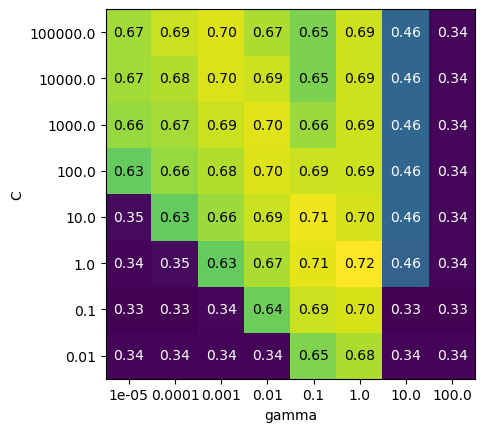

In [37]:
import mglearn

scores = np.array(results.mean_test_score).reshape(8, 8)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=params['gamma'],
                      ylabel='C', yticklabels=params['C'], cmap="viridis")


In [31]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,39.014662,0.653563,10.748041,0.183337,0.01,0.001,"{'C': 0.01, 'gamma': 0.001}",0.340760,0.340760,0.340760,...,0.337769,0.006055,32,0.340815,0.340815,0.340815,0.340779,0.325700,0.337785,0.006042
1,37.367550,1.833977,10.567540,0.231543,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.340616,0.341375,0.342892,...,0.338289,0.006364,31,0.342008,0.341584,0.343685,0.340779,0.326056,0.338822,0.006453
2,34.064661,0.232444,9.843047,0.124698,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.647681,0.657318,0.642715,...,0.648815,0.005477,19,0.652787,0.648940,0.652120,0.649567,0.652432,0.651169,0.001591
3,35.780592,1.172500,9.604026,0.061365,0.01,1.0,"{'C': 0.01, 'gamma': 1.0}",0.665309,0.689156,0.674226,...,0.675903,0.007901,15,0.681470,0.675206,0.679082,0.679704,0.676862,0.678465,0.002197
4,31.631121,0.211943,10.624068,0.243317,0.01,10.0,"{'C': 0.01, 'gamma': 10.0}",0.340760,0.340760,0.340760,...,0.337769,0.006055,32,0.340815,0.340815,0.340815,0.340779,0.325700,0.337785,0.006042
5,28.341032,0.140980,10.603735,0.153886,0.01,100.0,"{'C': 0.01, 'gamma': 100.0}",0.340760,0.340760,0.340760,...,0.337769,0.006055,32,0.340815,0.340815,0.340815,0.340779,0.325700,0.337785,0.006042
6,34.767391,0.359962,10.624321,0.232539,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.350987,0.348018,0.353017,...,0.341366,0.011512,26,0.349706,0.350126,0.354349,0.326890,0.327583,0.341731,0.011948
7,31.989408,1.217439,10.083078,0.114380,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.635841,0.639248,0.622851,...,0.635670,0.006694,20,0.637182,0.638090,0.641419,0.636943,0.633085,0.637344,0.002664
8,28.476599,0.252929,8.103482,0.151915,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.692262,0.697609,0.681696,...,0.692864,0.005876,10,0.700567,0.696338,0.701198,0.698737,0.700477,0.699464,0.001763
9,29.515477,1.980318,8.481101,0.386621,0.1,1.0,"{'C': 0.1, 'gamma': 1.0}",0.691061,0.713773,0.697239,...,0.699154,0.007678,6,0.722045,0.715601,0.721901,0.719089,0.720091,0.719745,0.002352
